# An example for GPinv.multilatent_model.py

This notebook demonstrates the inference of an inverse problem with multiple latent function.

*Keisuke Fujii 18th Sept. 2016*

## Synthetic observation

We want to infer the local emission intensity, circumferential flow velocity, and local temperature based on multiple emission spectra observed with multiple $N$ lines of sight, as shown below.

We assume there are no radial flow.

<img src=figs/abel_inversion.png width=240pt> <img src=figs/los_theta.png width=180pt>

The local emission intensity $a(r)$, local flow velocity $v(r)$, and local temperature $\sigma(r)$ are functions of radius $r$.

The local spectrum $\mathbf{y}_{i,j}$ from $i$-th shell with radius $r_i$  measured with the $j$-th sight line can be written as
$$
\mathbf{y}_{i,j} = \frac{a(r_i)}{\sqrt{2\pi}\sigma_i}\exp\left[ - 
\frac{(\lambda-\lambda_0 v_i/c \cos\theta_{i,j})^2}{2\sigma_i^2}  
\right]
$$

where $\theta_{i,j}$ is an angle between the $i$-th shell and $j$-th sight line.

## Non-linear model and transform

We assume $\log a$, $v$, $\log \sigma$ follow Gaussian process 
with kernel $\mathrm{K_a}$, $\mathrm{K_v}$, $\mathrm{K_\theta}$, respecvitvely.

## Import several libraries including GPinv

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

import tensorflow as tf
import sys
# In ../testing/ dir, we prepared a small script for generating the above matrix A
sys.path.append('../testing/')
from make_LosMatrix import make_LosMatrix, make_cosTheta
# Import GPinv
import GPinv

## Synthetic signals

Here, we make a synthetic measurement.

In [2]:
n = 30 # radial coordinate 
N = 40 # number of cite lines
# radial coordinate
r = np.linspace(0, 1., n)
# synthetic latent function
a = np.exp(-(r-0.3)*(r-0.3)/0.1) + np.exp(-(r+0.3)*(r+0.3)/0.1)
v = 3.*np.exp(-(r-0.6)*(r-0.6)/0.05)*(r-0.6)
sigma = np.exp(-(r-0.0)*(r-0.0)/0.3) + 0.3

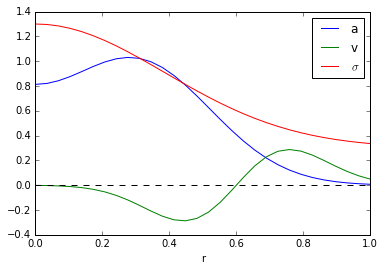

In [3]:
# plotting the latent function
plt.plot(r, a, label='a')
plt.plot(r, v, label='v')
plt.plot(r, sigma, label='$\sigma$')
plt.plot([0,1], [0,0], '--k')
plt.xlabel('r')
plt.legend()

### Prepare the synthetic signal.

In [4]:
# los height
z = np.linspace(-0.9,0.9, N)
# Los-matrix
A = make_LosMatrix(r, z)
cosTheta = make_cosTheta(r,z)

In [5]:
# Wavelength coordinate
# number of coordinate
m = 50
# coordinate 
lam = np.linspace(-3,3,50)

In [6]:
# noise amplitude 
e_amp = 0.1

In [7]:
# true (synthetic) signals.
f_true = np.zeros((m, N, n))
for i in range(N):
    for j in range(n):
        f_true[:,i,j] = a[j] / (np.sqrt(2*np.pi)*sigma[j]) * np.exp(-(lam-v[j]*cosTheta[i,j])**2)

In [8]:
# synthetic observation
y_syn = np.zeros((m,N))
for i in range(N):
    for j in range(n):
        y_syn[:,i] += A[i,j] * f_true[:,i,j]
y_syn+=np.random.randn(m,N)*0.01

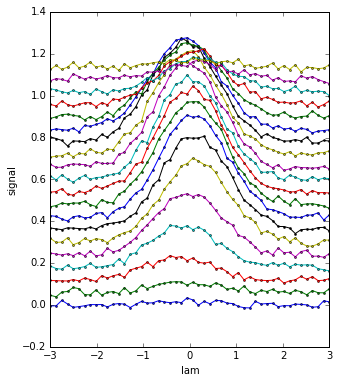

In [9]:
# plot
plt.figure(figsize=(5,6))
for i in range(0,N,2):
    plt.plot(lam, y_syn[:,i]+0.03*i, '-o', ms=2)
plt.xlabel('lam')
plt.ylabel('signal')

In [10]:
# for the simplicity, we concatenate y_syn into large vector,
y = np.hstack([y_syn[:,i] for i in range(N)])

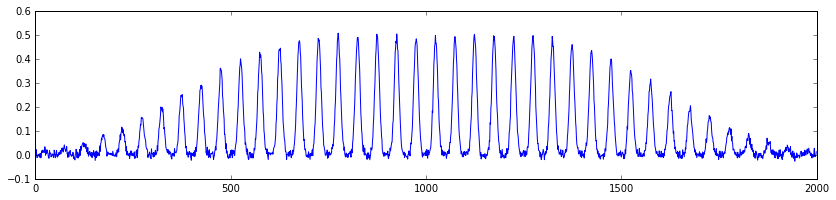

In [11]:
plt.figure(figsize=(14,3))
plt.plot(y)

# Inference

In order to carry out an inference, a custom **likelihood**, which calculates $p(\mathbf{Y}|\mathbf{f}_a,\mathbf{f}_v,\mathbf{f}_\sigma)$, must be prepared according to the problem.

In entire **GPinv**, we assume that the observed signal $\mathbf{y}$ is independent with conditioned by the latent functions $\mathbf{f}$, i.e.,
$$
p(\mathbf{Y}|\mathbf{f}_a,\mathbf{f}_v,\mathbf{f}_\sigma) = \prod_{i} p(y_i|\mathbf{f}_a,\mathbf{f}_v,\mathbf{f}_\sigma).
$$



In particular, we require two methods in **likelihood** class, 
i.e.
**transform** and **logp** methods.

In **transform** method, a transform from a GP function $\mathbf{f}$ to the latent value at the observation point should be described.

In **logp** method, the conditional probability for each data point should be described.

In [12]:
class AbelLikelihood(GPinv.multilatent_likelihoods.MultilatentLikelihood):
    def __init__(self, Amat, cosTheta, lam, num_samples=20):
        GPinv.multilatent_likelihoods.MultilatentLikelihood.__init__(self, num_samples, link_func=GPinv.link_functions.Log())
        # store A, cosTheta, lam as data
        self.Amat = GPinv.param.DataHolder(A)
        self.cosTheta = GPinv.param.DataHolder(cosTheta)
        self.lam = GPinv.param.DataHolder(lam)
        # gaussian noise is assumed. The variance parameter will be inferred.
        self.variance = GPinv.param.Param(np.ones(1), GPinv.transforms.positive)

    def transform(self, F_list):
        """
        Transform of the latent functions to latent values.
        :param list of tf.tensor F_lit:
                        Samples for latent functions. Each tensor is sized
                        [num_samples, N, M]
        :return tf.tensor: Samples for the latent values at Y, sized
                                                        [num_samples', N', M']
        The return value should be real and vary around some values.
        E.G. the latent values that is limited to positive space should be
        projected into the entire real space by Log transform.        
        """
        # map to positive space
        a,v,s = tf.exp(F_list[0]), F_list[1], tf.exp(F_list[2])
        # shape [k, N, M]
        k,N,M = tf.shape(a)[0],tf.shape(a)[1],tf.shape(a)[2]
        m = tf.shape(self.lam)[0]  # number of wavelength points
        n = tf.shape(self.Amat)[0] # number of sight lines
        # expand a, v, sig [k,N,M] -> [k,m,n,N,M]
        a = tf.tile(tf.expand_dims(tf.expand_dims(a,1),1), [1,m,n,1,1]) # map to positive space
        v = tf.tile(tf.expand_dims(tf.expand_dims(v,1),1), [1,m,n,1,1])
        s = tf.tile(tf.expand_dims(tf.expand_dims(s,1),1), [1,m,n,1,1]) # map to positive space
        # expand Amat and cosTheta [n,N] -> [k,m,n,N,M]
        Amat    = tf.tile(
            tf.expand_dims(tf.expand_dims(tf.expand_dims(self.Amat,     0),0),-1), [k,m,1,1,M])
        cosTheta= tf.tile(
            tf.expand_dims(tf.expand_dims(tf.expand_dims(self.cosTheta, 0),0),-1), [k,m,1,1,M])
        # expand lam [m] -> [k,m,n,N,M]
        lam = tf.tile(
            tf.expand_dims(tf.expand_dims(tf.expand_dims(tf.expand_dims(self.lam, 0),-1),-1),-1), [k,1,n,N,M])
        # synthetic function
        f = a / (np.sqrt(2*np.pi)*s) * tf.exp(-0.5*tf.square((lam - v * cosTheta)/s))
        # line integration
        Af = tf.reduce_sum(Amat * f, 3)
        # reshape
        return tf.reshape(tf.transpose(Af, [0,2,1,3]), [k,m*n,M])

    def log_p(self, X, Y):
        """
        X is the latent value with respect to the observation Y.
        X, Y shape is [P, N, M]
        """
        return GPinv.densities.gaussian(X, Y, self.variance)

In [13]:
lik = AbelLikelihood(A, cosTheta, lam)

## Prepare Model-Input

For the model construction, we need to prepare a set of **ModelInput** according to each latent function.

In ModelInput object, we need to pass (at least) the **coordinate**, **kernel**, **mean_function**.
+ kernel: Since $f$ is a cylindrically symmetric function, we adopt **RBF_csym** kernel.
+ mean_function: Since we map $a$ and $\sigma$ by log function, we adopt **Constant** mean_function.

In [14]:
input_a = GPinv.multilatent_models.ModelInput(r.reshape(-1,1),GPinv.kernels.RBF_csym(1),
                                              Z = np.linspace(0.2,0.95,10).reshape(-1,1),
                                              mean_function=GPinv.mean_functions.Constant(-1*np.ones(1)))
input_v = GPinv.multilatent_models.ModelInput(r.reshape(-1,1),GPinv.kernels.RBF_csym(1),
                                              Z = np.linspace(0.2,0.95,10).reshape(-1,1))
input_s = GPinv.multilatent_models.ModelInput(r.reshape(-1,1),GPinv.kernels.RBF_csym(1),
                                              Z = np.linspace(0.2,0.95,10).reshape(-1,1),
                                              mean_function=GPinv.mean_functions.Constant(-1*np.ones(1)))

In [15]:
# The set of model-inputs should be set int ModelInputSet
input_set = GPinv.multilatent_models.ModelInputSet([input_a, input_v, input_s])

# Inference by GPMC

In [16]:
model_gpmc = GPinv.multilatent_gpmc.MultilatentGPMC(input_set, y.reshape(-1,1), likelihood=lik)

In [17]:
model_gpmc._compile()
print(model_gpmc._objective(model_gpmc.get_free_state()))

(array([ 1934.75847652]), array([  3.89050389e+01,   8.95263973e+00,   9.91913343e+00,
         3.44847948e+00,   1.45497895e+00,   8.41849932e-01,
         6.90368734e-01,   7.63326673e-01,   9.51606003e-01,
         1.12367620e+00,   1.13799569e+00,   9.75523636e-01,
         7.43116334e-01,   5.34583234e-01,   3.78962308e-01,
         2.71426446e-01,   1.99387734e-01,   1.51793015e-01,
         1.20109952e-01,   9.86059171e-02,   8.30385122e-02,
         7.01427129e-02,   5.74829792e-02,   4.48979810e-02,
         3.32339613e-02,   2.32141674e-02,   1.50638104e-02,
         9.00383424e-03,   4.91677319e-03,   1.65919942e-03,
         2.10427068e+00,   1.26719082e-01,   1.39377423e-01,
         4.79092217e-02,   1.92893093e-02,   9.40207838e-03,
         4.91712148e-03,   2.35151433e-03,   4.26933974e-04,
        -1.15461638e-03,  -2.31544685e-03,  -2.62247571e-03,
        -2.43120685e-03,  -2.06000431e-03,  -1.81362904e-03,
        -1.49655841e-03,  -1.26556660e-03,  -1.09856701e-03

In [ ]:
samples = model_gpmc.sample(num_samples=2000, thin=1, burn=1000, epsilon=0.001, verbose=True)

burn-in sampling started
Iteration:  100 	 Acc Rate:  98.0 %
Iteration:  200 	 Acc Rate:  98.0 %
Iteration:  300 	 Acc Rate:  94.0 %


# Result

Plot the temporal evolution of hyperparamter to make sure the MCMC fell into equilibrium.

In [ ]:
length0, length1, length2 = [],[],[]
variance0,variance1,variance2 = [],[],[]
lik_var = []
for s in samples:
    model_gpmc.set_state(s)
    length0.append(model_gpmc.kern.kern_list[0].lengthscales.value[0])
    length1.append(model_gpmc.kern.kern_list[1].lengthscales.value[0])
    length2.append(model_gpmc.kern.kern_list[2].lengthscales.value[0])
    variance0.append(model_gpmc.kern.kern_list[0].variance.value[0])
    variance1.append(model_gpmc.kern.kern_list[1].variance.value[0])
    variance2.append(model_gpmc.kern.kern_list[2].variance.value[0])
    lik_var.append(model_gpmc.likelihood.variance.value[0])

In [ ]:
plt.figure(figsize=(15,5))
# --- plot the kernel length scales---
plt.subplot(1,3,1)
plt.plot(length0)
plt.plot(length1)
plt.plot(length2)
# --- plot the kernel variance---
plt.subplot(1,3,2)
plt.plot(variance0)
plt.plot(variance1)
plt.plot(variance2)
# --- plot the likelihood variance---
plt.subplot(1,3,3)
plt.plot(lik_var)

TypeError: Expected binary or unicode string, got <GPinv.param.ConcatDataHolder object at 0x7fa0b6ab5668>

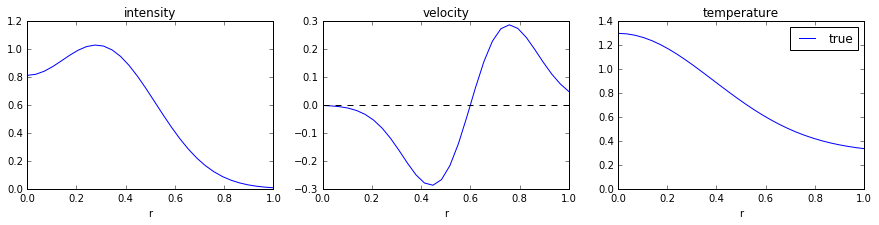

In [21]:
plt.figure(figsize=(15,3))
# --- observed and grand truth ---
plt.subplot(1,3,1)
plt.title('intensity')
plt.plot(r, a, label='true')
plt.plot([0,1], [0,0], '--k')
plt.xlabel('r')
plt.subplot(1,3,2)
plt.title('velocity')
plt.plot(r, v, label='true')
plt.plot([0,1], [0,0], '--k')
plt.xlabel('r')
plt.subplot(1,3,3)
plt.title('temperature')
plt.plot(r, sigma, label='true')
plt.plot([0,1], [0,0], '--k')
plt.xlabel('r')
plt.legend()

# ---  GPMC  ---
a_pred = []
v_pred = []
s_pred = []
for s in samples[1000::5]:
    model_gpmc.set_state(s)
    f_pred, f_mu = model_gpmc.predict_f([r.reshape(-1,1),r.reshape(-1,1),r.reshape(-1,1)])
    g_pred, g_mu = model_gpmc.predict_g()
    a_pred.append(np.exp(f_pred[0]))
    v_pred.append(       f_pred[1])
    s_pred.append(np.exp(f_pred[2]))
    plt.subplot(1,3,1)
    plt.plot(r, np.exp(f_pred[0]),'k', alpha=0.1)
    plt.subplot(1,3,2)
    plt.plot(r, f_pred[1],'k', alpha=0.1)
    plt.subplot(1,3,3)
    plt.plot(r, np.exp(f_pred[2]),'k', alpha=0.1)

# --- plotting median ----
plt.subplot(1,3,1)
plt.plot(r, np.median(a_pred),'k')
plt.subplot(1,3,2)
plt.plot(r, np.median(v_pred),'k')
plt.subplot(1,3,3)
plt.plot(r, np.median(s_pred),'k')

In [ ]:
r_new = np.linspace(0.,1., 30)
plt.figure(figsize=(15,5))

# --- observed and grand truth ---
plt.subplot(1,2,1)
plt.plot(r, f, '-r', label='true',lw=2)
plt.plot([0,1],[0,0],'--k')
plt.subplot(1,2,2)
plt.plot(z, y, 'bo',lw=2, label='observed')
plt.plot(z, np.dot(A, f), 'r', label='true')

# ---  GPMC  ---
f_pred_set=[]
y_pred_set=[]
for s in samples[::5]:
    model_mc.set_state(s)
    f_pred = model_mc.predict_f(r_new.reshape(-1,1))
    f_pred_set.append(np.exp(f_pred[0]))
    plt.subplot(1,2,1)
    plt.plot(r_new, np.exp(f_pred[0]),'k', alpha=0.1)
    plt.subplot(1,2,2)
    y_pred = np.dot(A, np.exp(f_pred[0]))
    y_pred_set.append(y_pred)
    plt.plot(z, y_pred,'k', alpha=0.1)

# median
plt.subplot(1,2,1)
plt.plot(r_new, np.median(f_pred_set, axis=0),'k', label='gpmc')
plt.subplot(1,2,2)
plt.plot(z, np.median(y_pred_set, axis=0),'k', label='gpmc')

# --- vgp ---
plt.subplot(1,2,1)
f_pred, f_var = model_vgp.predict_f(r_new.reshape(-1,1))
f_plus = np.exp(f_pred.flatten() + 2.*np.sqrt(f_var.flatten()))
f_minus = np.exp(f_pred.flatten() - 2.*np.sqrt(f_var.flatten()))
plt.fill_between(r_new, f_plus, f_minus, facecolor='g', alpha=0.2)
plt.plot(r_new, np.exp(f_pred.flatten()), 'g', label='vgp')
plt.subplot(1,2,2)
plt.plot(z, np.dot(A, np.exp(f_pred.flatten())), 'g', label='vgp')

plt.subplot(1,2,1)
plt.legend()
plt.subplot(1,2,2)
plt.legend()

In [88]:
model_gpmc._compile()

/home/keisukefujii/anaconda3/envs/tensorflow/lib/python3.5/site-packages/tensorflow/python/ops/array_ops.py:1750: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  result_shape.insert(dim, 1)


In [89]:
F_list = [-1*np.ones((2,n,1)),np.zeros((2,n,1)),-0.5*np.ones((2,n,1))]
with model_gpmc.tf_mode():
    trans_f = model_gpmc._session.run(model_gpmc.likelihood.transform(F_list), model_gpmc.get_feed_dict())

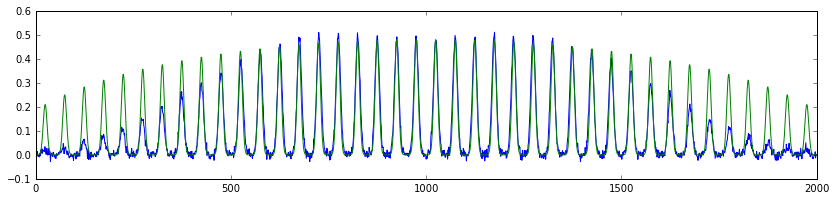

In [90]:
plt.figure(figsize=(14,3))
plt.plot(y)
plt.plot(np.exp(trans_f[1,:,0]))

In [91]:
print(model_gpmc._objective(model_gpmc.get_free_state()))

(array([ 2620.78626984]), array([  1.94331053e+01,   4.46804757e+00,   4.95039013e+00,
         1.72104224e+00,   7.26126552e-01,   4.20107568e-01,
         3.44472209e-01,   3.80829234e-01,   4.74725293e-01,
         5.60539952e-01,   5.67667036e-01,   4.86611566e-01,
         3.70674747e-01,   2.66651899e-01,   1.89022261e-01,
         1.35377874e-01,   9.94415999e-02,   7.56993469e-02,
         5.98911313e-02,   4.91664112e-02,   4.14023947e-02,
         3.49639332e-02,   2.86525019e-02,   2.23756129e-02,
         1.65591953e-02,   1.15695656e-02,   7.50278771e-03,
         4.48497199e-03,   2.45007283e-03,   8.26960535e-04,
         1.11353500e+00,   7.21751131e-02,   7.94410556e-02,
         2.73338955e-02,   1.10446713e-02,   5.46386235e-03,
         3.01112315e-03,   1.70056297e-03,   7.99187015e-04,
         6.08438277e-05,  -5.48124290e-04,  -8.09090607e-04,
        -8.44975301e-04,  -7.72603458e-04,  -7.31606452e-04,
        -6.28597351e-04,  -5.45501497e-04,  -4.89628875e-04

In [43]:
# optimization
_= model_svgp.optimize(tf.train.AdamOptimizer(learning_rate=0.00001), maxiter=1)

/home/keisukefujii/anaconda3/envs/tensorflow/lib/python3.5/site-packages/tensorflow/python/ops/array_ops.py:1750: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  result_shape.insert(dim, 1)


InvalidArgumentError: Input matrix is not invertible.
	 [[Node: model.build_likelihood_6/multilatent_conditional/MatrixTriangularSolve = MatrixTriangularSolve[T=DT_DOUBLE, adjoint=false, lower=true, _device="/job:localhost/replica:0/task:0/cpu:0"](model.build_likelihood_6/multilatent_conditional/Add_1, model.build_likelihood_6/multilatent_conditional/model.kern.K/Add_1)]]
Caused by op 'model.build_likelihood_6/multilatent_conditional/MatrixTriangularSolve', defined at:
  File "/home/keisukefujii/anaconda3/envs/tensorflow/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/keisukefujii/anaconda3/envs/tensorflow/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/keisukefujii/anaconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/keisukefujii/anaconda3/envs/tensorflow/lib/python3.5/site-packages/traitlets/config/application.py", line 596, in launch_instance
    app.start()
  File "/home/keisukefujii/anaconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 442, in start
    ioloop.IOLoop.instance().start()
  File "/home/keisukefujii/anaconda3/envs/tensorflow/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 162, in start
    super(ZMQIOLoop, self).start()
  File "/home/keisukefujii/anaconda3/envs/tensorflow/lib/python3.5/site-packages/tornado/ioloop.py", line 883, in start
    handler_func(fd_obj, events)
  File "/home/keisukefujii/anaconda3/envs/tensorflow/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/keisukefujii/anaconda3/envs/tensorflow/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/keisukefujii/anaconda3/envs/tensorflow/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/keisukefujii/anaconda3/envs/tensorflow/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/keisukefujii/anaconda3/envs/tensorflow/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/keisukefujii/anaconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/keisukefujii/anaconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/keisukefujii/anaconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 391, in execute_request
    user_expressions, allow_stdin)
  File "/home/keisukefujii/anaconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 199, in do_execute
    shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/keisukefujii/anaconda3/envs/tensorflow/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/keisukefujii/anaconda3/envs/tensorflow/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/keisukefujii/anaconda3/envs/tensorflow/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-43-09402d5ff588>", line 2, in <module>
    _= model_svgp.optimize(tf.train.AdamOptimizer(learning_rate=0.00001), maxiter=1)
  File "/home/keisukefujii/Dropbox/projects/GPflow.git/GPflow/model.py", line 220, in optimize
    return self._optimize_tf(method, callback, maxiter, **kw)
  File "/home/keisukefujii/Dropbox/projects/GPflow.git/GPflow/model.py", line 226, in _optimize_tf
    opt_step = self._compile(optimizer=method)
  File "/home/keisukefujii/Dropbox/projects/GPflow.git/GPflow/model.py", line 131, in _compile
    f = self.build_likelihood() + self.build_prior()
  File "/home/keisukefujii/Dropbox/projects/GPflow.git/GPflow/scoping.py", line 41, in runnable
    return f(*args, **kwargs)
  File "/home/keisukefujii/anaconda3/envs/tensorflow/lib/python3.5/site-packages/GPinv-0.0.1-py3.5.egg/GPinv/svgp.py", line 90, in build_likelihood
    fmean, fcov = self.build_predict(self.X, full_cov=True)
  File "/home/keisukefujii/anaconda3/envs/tensorflow/lib/python3.5/site-packages/GPinv-0.0.1-py3.5.egg/GPinv/multilatent_svgp.py", line 92, in build_predict
    q_sqrt=self.q_sqrt, full_cov=full_cov, whiten=self.whiten)
  File "/home/keisukefujii/Dropbox/projects/GPflow.git/GPflow/scoping.py", line 41, in runnable
    return f(*args, **kwargs)
  File "/home/keisukefujii/anaconda3/envs/tensorflow/lib/python3.5/site-packages/GPinv-0.0.1-py3.5.egg/GPinv/multilatent_conditionals.py", line 41, in conditional
    A = tf.matrix_triangular_solve(Lm, Kmn, lower=True)
  File "/home/keisukefujii/anaconda3/envs/tensorflow/lib/python3.5/site-packages/tensorflow/python/ops/gen_linalg_ops.py", line 585, in matrix_triangular_solve
    name=name)
  File "/home/keisukefujii/anaconda3/envs/tensorflow/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 703, in apply_op
    op_def=op_def)
  File "/home/keisukefujii/anaconda3/envs/tensorflow/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2317, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/keisukefujii/anaconda3/envs/tensorflow/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1239, in __init__
    self._traceback = _extract_stack()


## Inference by vanilla MCMC (GPMC)

In [10]:
# Instantiate model, with kernel coordinate r, observation y, kernel, likelihood and mean.
model_mc = GPinv.nonlinear_model.GPMC(r.reshape(-1,1), y.reshape(-1,1), 
                                   kern = kern, 
                                   mean_function = GPinv.mean_functions.Constant(np.ones(1)),
                                   likelihood=AbelLikelihood(A))

In [11]:
# Initialization of parameter sometimes necessary.
model_mc.likelihood.variance=0.1

In [12]:
# make sampling 
samples = model_mc.sample(500, burn=400, verbose=True)

burn-in sampling started
Iteration:  100 	 Acc Rate:  98.0 %
Iteration:  200 	 Acc Rate:  99.0 %
Iteration:  300 	 Acc Rate:  94.0 %
Iteration:  400 	 Acc Rate:  98.0 %
burn-in sampling ended
Iteration:  100 	 Acc Rate:  82.0 %
Iteration:  200 	 Acc Rate:  90.0 %
Iteration:  300 	 Acc Rate:  90.0 %
Iteration:  400 	 Acc Rate:  98.0 %
Iteration:  500 	 Acc Rate:  86.0 %


## Variational inference by VGP

In [13]:
model_vgp = GPinv.nonlinear_model.VGP(r.reshape(-1,1), y.reshape(-1,1), 
                           kern = GPinv.kernels.RBF_csym(1),
                           mean_function = GPinv.mean_functions.Constant(-2.*np.ones(1)),
                           likelihood=AbelLikelihood(A, 40))

In [14]:
_= model_vgp.optimize(tf.train.AdamOptimizer(learning_rate=0.05), maxiter=5000)

## Sparse approximation of VGP by SVGP

In [15]:
# number of minibatch size of data
minibatch_size = 20
# number of inducing point in GP approximation.
inducing = 10

model_svgp = GPinv.nonlinear_model.SVGP(r.reshape(-1,1), y.reshape(-1,1),
                            kern = GPinv.kernels.RBF_csym(1),
                            likelihood = AbelLikelihood_minibatch(A, minibatch_size),
                            mean_function = GPinv.mean_functions.Constant(-2.*np.ones(1)),
                            Z = np.linspace(0, 1., inducing).reshape(-1,1),
                            minibatch_size=minibatch_size)

In [16]:
_= model_svgp.optimize(tf.train.AdamOptimizer(learning_rate=0.05), maxiter=5000)

# Result

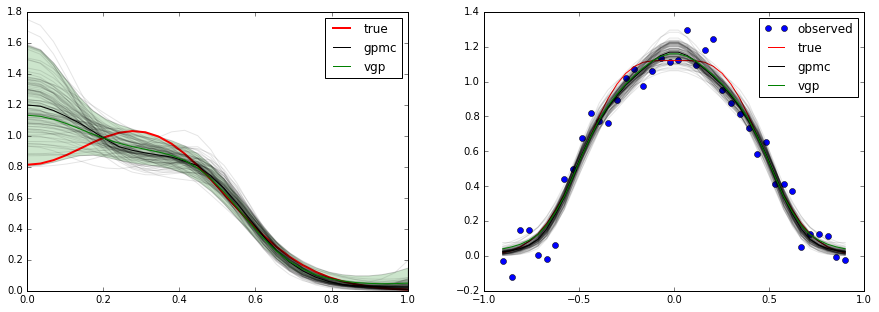

In [17]:
r_new = np.linspace(0.,1., 30)
plt.figure(figsize=(15,5))

# --- observed and grand truth ---
plt.subplot(1,2,1)
plt.plot(r, f, '-r', label='true',lw=2)
plt.plot([0,1],[0,0],'--k')
plt.subplot(1,2,2)
plt.plot(z, y, 'bo',lw=2, label='observed')
plt.plot(z, np.dot(A, f), 'r', label='true')

# ---  GPMC  ---
f_pred_set=[]
y_pred_set=[]
for s in samples[::5]:
    model_mc.set_state(s)
    f_pred = model_mc.predict_f(r_new.reshape(-1,1))
    f_pred_set.append(np.exp(f_pred[0]))
    plt.subplot(1,2,1)
    plt.plot(r_new, np.exp(f_pred[0]),'k', alpha=0.1)
    plt.subplot(1,2,2)
    y_pred = np.dot(A, np.exp(f_pred[0]))
    y_pred_set.append(y_pred)
    plt.plot(z, y_pred,'k', alpha=0.1)

# median
plt.subplot(1,2,1)
plt.plot(r_new, np.median(f_pred_set, axis=0),'k', label='gpmc')
plt.subplot(1,2,2)
plt.plot(z, np.median(y_pred_set, axis=0),'k', label='gpmc')

# --- vgp ---
plt.subplot(1,2,1)
f_pred, f_var = model_vgp.predict_f(r_new.reshape(-1,1))
f_plus = np.exp(f_pred.flatten() + 2.*np.sqrt(f_var.flatten()))
f_minus = np.exp(f_pred.flatten() - 2.*np.sqrt(f_var.flatten()))
plt.fill_between(r_new, f_plus, f_minus, facecolor='g', alpha=0.2)
plt.plot(r_new, np.exp(f_pred.flatten()), 'g', label='vgp')
plt.subplot(1,2,2)
plt.plot(z, np.dot(A, np.exp(f_pred.flatten())), 'g', label='vgp')

plt.subplot(1,2,1)
plt.legend()
plt.subplot(1,2,2)
plt.legend()

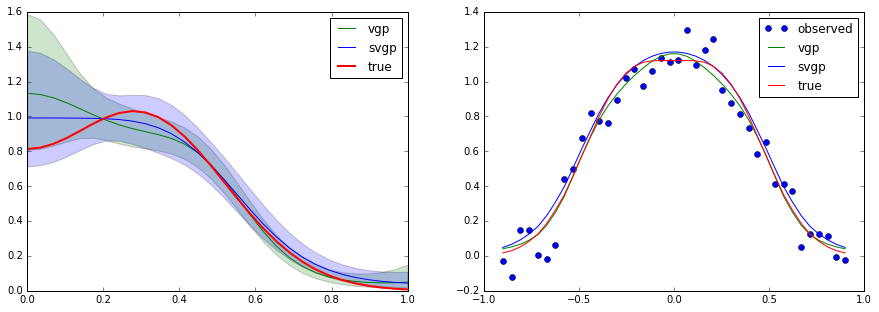

In [18]:
r_new = np.linspace(0.,1., 30)

plt.figure(figsize=(15,5))
plt.subplot(1,2,2)
plt.plot(z, y, 'bo',lw=2, label='observed')

# plot vgp
plt.subplot(1,2,1)
f_pred, f_var = model_vgp.predict_f(r_new.reshape(-1,1))
f_plus = np.exp(f_pred.flatten() + 2.*np.sqrt(f_var.flatten()))
f_minus = np.exp(f_pred.flatten() - 2.*np.sqrt(f_var.flatten()))
plt.fill_between(r_new, f_plus, f_minus, facecolor='g', alpha=0.2)
plt.plot(r_new, np.exp(f_pred.flatten()), 'g', label='vgp')

plt.subplot(1,2,2)
plt.plot(z, np.dot(A, np.exp(f_pred.flatten())), 'g', label='vgp')

# plot svgp
plt.subplot(1,2,1)
f_pred, f_var = model_svgp.predict_f(r_new.reshape(-1,1))
f_plus = np.exp(f_pred.flatten() + 2.*np.sqrt(f_var.flatten()))
f_minus = np.exp(f_pred.flatten() - 2.*np.sqrt(f_var.flatten()))
plt.fill_between(r_new, f_plus, f_minus, facecolor='b', alpha=0.2)
plt.plot(r_new, np.exp(f_pred.flatten()), 'b', label='svgp')

plt.subplot(1,2,2)
plt.plot(z, np.dot(A, np.exp(f_pred.flatten())), 'b', label='svgp')

# grand truth
plt.subplot(1,2,1)
plt.plot(r, f, '-r', label='true',lw=2)
plt.plot([0,1],[0,0],'--k')
plt.legend()

plt.subplot(1,2,2)
plt.plot(z, np.dot(A, f), 'r', label='true')

plt.legend()